In [1]:
import datetime
import math
import numpy as np
import scipy as sp
import scipy.fftpack
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
#matplotlib inline
import pyproj
import pymap3d as pm

from astropy.time import Time



In [2]:
## input data
data = pd.read_csv("data/prkv0070000.cts", sep=" ")
#data["dates"]
data['Lat'], data['Lon'], data['Alt'] = pm.ecef2geodetic(data['X'], data['Y'], data['Z'], ell=None, deg=True)
#data['ddate'] = pd.to_datetime(data['dates'], format='%d/%m/%Y')
#data['date'] = pd.to_datetime(data.date + data.h.astype(str),format='%d/%m/%Y %H').dt.time
#data['date']
#data['time'] =data['h'].astype(str) +':'+ data['min'].astype(str)+':'+data['sec'].astype(str)
#data['date'] = pd.to_datetime(data['ddate'].astype(str) +' '+ data['time'].astype(str))
#data['jd'] = data['mjd'] + 2400000.5

data['mjdTim'] = data['mjd']+data['sod']/(3600*24)

data['Date'] = Time(data['mjdTim'], format='mjd').datetime

#P = pyproj.Proj(proj='utm', zone=34, ellps='WGS84', preserve_units=False)
#data['utmE'], data['utmN'] = P(data['Lon'], data['Lat'])

## set index
data = data.set_index(['Date'])
data
## convert and make index to dataframwe
#time_data = "3/4/2022 12:16:25.123"
#format_data = "%d/%m/%Y"
#date = datetime.strptime(data['dates'], format_data)
#data
header= ['X','Y','Z',]
data.to_csv('data/test_p2.txt', columns=header)
#utmout = data[['utmE', 'utmN', 'Alt']].copy()
#
#utmout
#utmout.to_csv('Outputs/utm_ts.txt')
data

,mjd,sod,X,Y,Z,Lat,Lon,Alt,mjdTim
Date,,,,,,,,,
2023-01-07 00:00:00,59951,0.0,4435581.321,2188830.554,4013585.965,39.245702,26.265001,169.666720,59951.000000
2023-01-07 00:00:30,59951,30.0,4435581.325,2188830.552,4013585.962,39.245702,26.265001,169.666915,59951.000347
2023-01-07 00:01:00,59951,60.0,4435581.334,2188830.555,4013585.966,39.245702,26.265001,169.676724,59951.000694
2023-01-07 00:01:30,59951,90.0,4435581.339,2188830.552,4013585.967,39.245702,26.265001,169.679801,59951.001042
2023-01-07 00:02:00,59951,120.0,4435581.343,2188830.552,4013585.969,39.245702,26.265001,169.683844,59951.001389
...,...,...,...,...,...,...,...,...,...
2023-01-07 17:15:00,59951,62100.0,4435581.284,2188830.554,4013585.938,39.245702,26.265001,169.623943,59951.718750
2023-01-07 17:15:30,59951,62130.0,4435581.295,2188830.555,4013585.929,39.245702,26.265001,169.626231,59951.719097
2023-01-07 17:16:00,59951,62160.0,4435581.299,2188830.554,4013585.926,39.245702,26.265001,169.626768,59951.719444


In [3]:
## convert to E N UP
meanX=data['X'].mean()
meanY=data['Y'].mean()
meanZ=data['Z'].mean()

ecef = pyproj.Proj(proj='geocent', ellps='WGS84', datum='WGS84')
lla = pyproj.Proj(proj='latlong', ellps='WGS84', datum='WGS84')
#mLon, mLat, mAlt = pyproj.transform(ecef, lla, meanX, meanY, meanZ, radians=False)
mLat, mLon, mAlt = pm.ecef2geodetic(meanX, meanY, meanZ,  ell=None, deg=True)


print(mLon, mLat, mAlt)

# mLon_r=math.radians(mLon)
# mLat_r=math.radians(mLat)
# print(meanLon, meanLat, meanAlt)

data['dX'] = data['X'] - meanX
data['dY'] = data['Y'] - meanY
data['dZ'] = data['Z'] - meanZ

## make rotational matrix
#R = [ 
#    [-math.sin(mLat_r)*math.cos(mLon_r), -math.sin(mLat_r)*math.sin(mLon_r), math.cos(mLat_r)],
#    [-math.sin(mLon_r), math.cos(mLon_r), 0],
#    [math.cos(mLat_r)*math.cos(mLon_r), math.cos(mLat_r)*math.sin(mLon_r), math.sin(mLat_r)]
#]


data['dN'], data['dE'], data['dU'] = pm.ecef2enu(data['X'], data['Y'], data['Z'], mLat, mLon, mAlt, ell=None, deg=True)
data['dN'] = data['dN']*1000.
data['dE'] = data['dE']*1000.
data['dU'] = data['dU']*1000.

#indexdN = data[ (data['dN'] >= 40) | (data['dN'] <=-40) ].index
#data.drop(indexdN , inplace=True)
header= ['X','Y','Z','dN', 'dE', 'dU']
data.to_csv('test_p.csv', columns=header)
data

26.265001143495574 39.24570237614847 169.61590568214604


,mjd,sod,X,Y,Z,Lat,Lon,Alt,mjdTim,dX,dY,dZ,dN,dE,dU
Date,,,,,,,,,,,,,,,
2023-01-07 00:00:00,59951,0.0,4435581.321,2188830.554,4013585.965,39.245702,26.265001,169.666720,59951.000000,0.044213,0.003658,0.029804,-16.284952,-3.025760,50.814426
2023-01-07 00:00:30,59951,30.0,4435581.325,2188830.552,4013585.962,39.245702,26.265001,169.666915,59951.000347,0.048213,0.001658,0.026804,-19.848560,-7.058481,51.009007
2023-01-07 00:01:00,59951,60.0,4435581.334,2188830.555,4013585.966,39.245702,26.265001,169.676724,59951.000694,0.057213,0.004658,0.030804,-21.141000,-9.906581,60.818080
2023-01-07 00:01:30,59951,90.0,4435581.339,2188830.552,4013585.967,39.245702,26.265001,169.679801,59951.001042,0.062213,0.001658,0.031804,-26.043889,-11.128911,63.895026
2023-01-07 00:02:00,59951,120.0,4435581.343,2188830.552,4013585.969,39.245702,26.265001,169.683844,59951.001389,0.066213,0.001658,0.033804,-27.813983,-11.849355,67.938259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-07 17:15:00,59951,62100.0,4435581.284,2188830.554,4013585.938,39.245702,26.265001,169.623943,59951.718750,0.007213,0.003658,0.002804,0.088417,-2.944404,8.037024
2023-01-07 17:15:30,59951,62130.0,4435581.295,2188830.555,4013585.929,39.245702,26.265001,169.626231,59951.719097,0.018213,0.004658,-0.006196,-3.882584,-16.434965,10.325236
2023-01-07 17:16:00,59951,62160.0,4435581.299,2188830.554,4013585.926,39.245702,26.265001,169.626768,59951.719444,0.022213,0.003658,-0.009196,-6.549435,-20.747647,10.862524


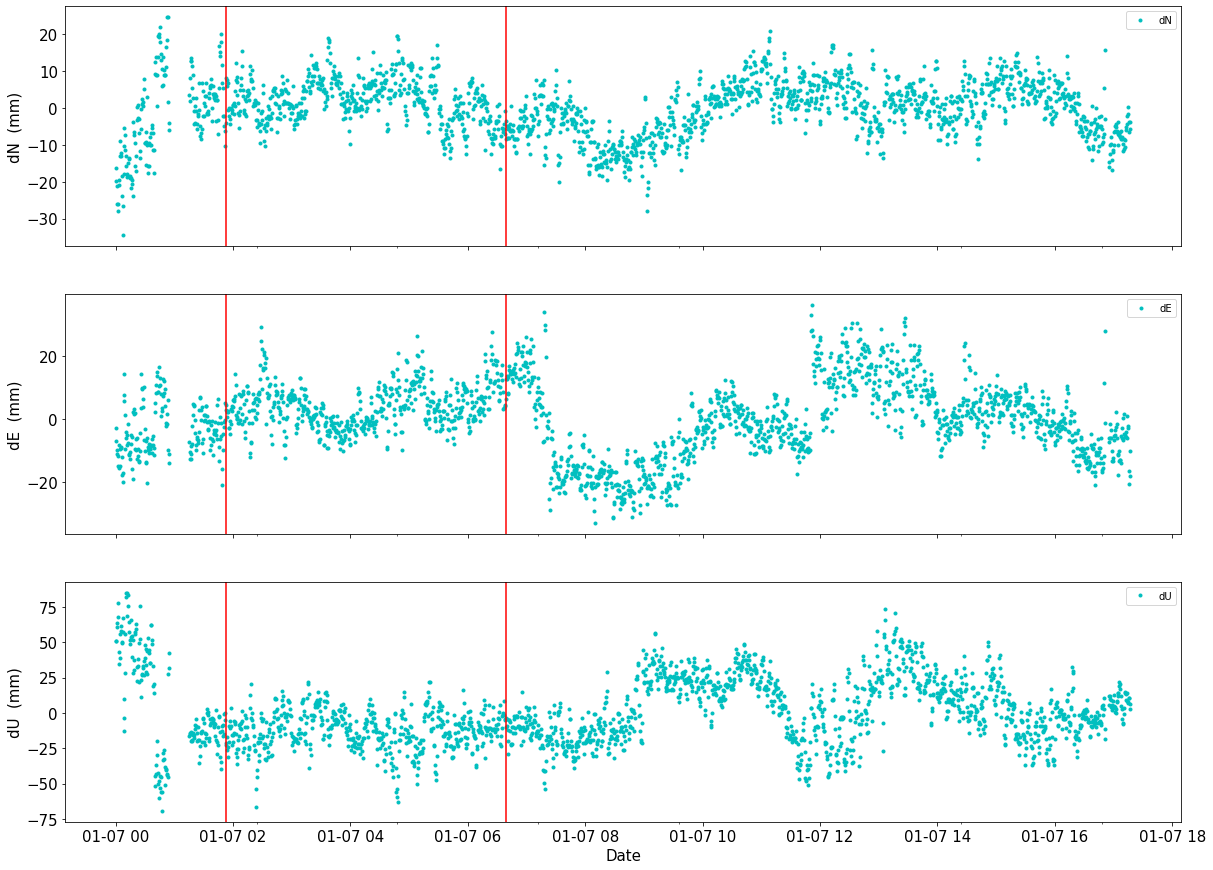

In [4]:
## make time series for the three axes
fig, axes = plt.subplots(3, 1, figsize=(20,15), sharex=True,)

plot_cols = ['dN', 'dE', 'dU' ]
#plot_cols = ['dX', 'dY', 'dZ' ]

data[plot_cols].plot(subplots=True, ax=axes, linestyle='', marker='.', color='c')

#month_day_formatter = mdates.DateFormatter("%Y-%m-%d")
month_day_formatter = mdates.DateFormatter("%H")

for ax, col in zip(axes, plot_cols):
    # add axis labels
    ax.set_ylabel(col + '  (mm)',fontsize=15)
    ax.set_xlabel('Date', fontsize=15)
#    ax.xaxis.set_major_formatter(month_day_formatter)
    # We change the fontsize of minor ticks label 
    ax.tick_params(axis='both', which='major', labelsize=15)
    #ax.tick_params(axis='both', which='minor', labelsize=8)
    #ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
##EVIA PERIVOLIA
    #ax.axvline(pd.Timestamp('2022-11-29 04:32:36'),color='r')
    #ax.axvline(pd.Timestamp('2022-11-29 20:06:39'),color='r')
##EVIA PSAXNA - XALKIDA
    ax.axvline(pd.Timestamp('2023-01-07 01:52:58'), color='r')
    ax.axvline(pd.Timestamp('2023-01-07 06:39:28'), color='r')
## Save the figure
## =================================================================================
#fig.savefig("Outputs/ts/timeseries_T8.png")
## =================================================================================

KeyError: "['utmE', 'utmN'] not in index"

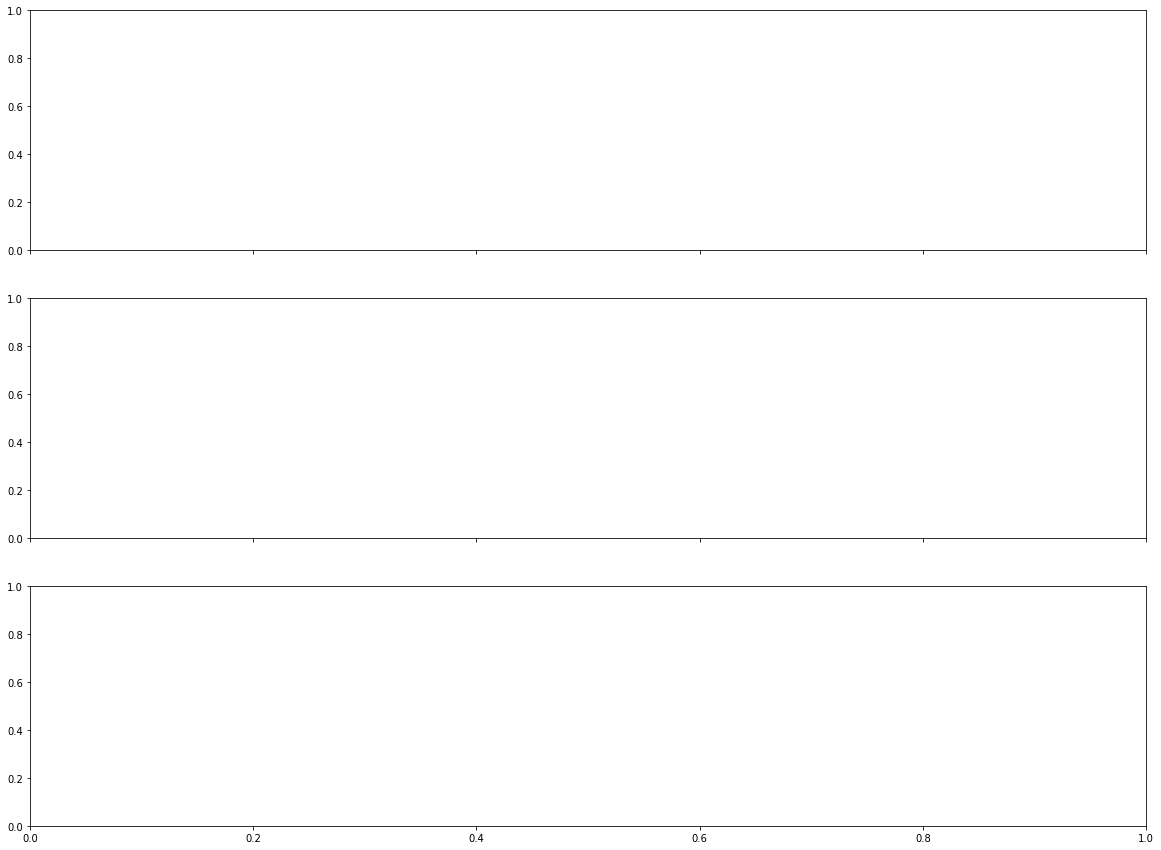

In [5]:
## make time series for the three axes
fig, axes = plt.subplots(3, 1, figsize=(20,15), sharex=True,)

plot_cols = ['utmE', 'utmN', 'Alt' ]

data[plot_cols].plot(subplots=True, ax=axes, linestyle='', marker='o', color='c')

month_day_formatter = mdates.DateFormatter("%Y-%m-%d")

for ax, col in zip(axes, plot_cols):
    # add axis labels
    ax.set_ylabel(col + '  (m)',fontsize=15)
    ax.set_xlabel('Date', fontsize=15)
    ax.xaxis.set_major_formatter(month_day_formatter)
    # We change the fontsize of minor ticks label 
    ax.tick_params(axis='both', which='major', labelsize=15)
    #ax.tick_params(axis='both', which='minor', labelsize=8)
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=15))
    
    
## Save the figure
## =================================================================================
#fig.savefig("Outputs/ts/timeseries_T8.png")
## =================================================================================


In [ ]:
cust = "+proj=tmerc +lat_0=49 +lon_0=-2 +k=0.9996012717 +x_0=59011 +y_0=-1001635 +ellps=airy +datum=OSGB36 +units=m +no_defs"
